In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../src/')
from train import load_data
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor
import magic
import torch
import pathlib
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [2]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridge
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset

In [3]:
entity = "xingzhis"
project = "dmae"
# sweep_id = 'dkz89w35'
sweep_id = 'kbu1w0ez'
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

In [4]:
df['cfg/data/root'].unique()

array(['../data/negative_sampling_toy/True/',
       '../data/negative_sampling_toy/False/', nan], dtype=object)

In [5]:
df[(df['cfg/data/name'] == 'eb') & (df['cfg/dimensions/latent'] == 3) & (df['cfg/data/root'] == '../data/negative_sampling_toy/True/') & (df['cfg/loss/weights/cycle'] == 0)]

,_step,_timestamp,train/cycle_loss_epoch,train/reconstr_loss_step,validation/reconstr_loss,train/reconstr_loss_epoch,_wandb,validation/loss,trainer/global_step,train/dist_loss_step,...,loss.weights.cycle_dist,cfg/decoder/layer_widths,cfg/encoder/layer_widths,cfg/training/accelerator,cfg/loss/weights/reconstr,cfg/training/weight_decay,cfg/loss/weights/cycle_dist,cfg/training/log_every_n_steps,cfg/training/train_valid_split,run_id
6,2019.0,1.714285e+09,NaN,12.969074,16.584272,13.167575,{'runtime': 6640},5.549130,191999.0,0.022355,...,0,"[64, 128, 256]","[256, 128, 64]",cuda,0.32,0.0001,0.0,100.0,0.8,6ex9ywx8
7,2019.0,1.714285e+09,NaN,14.172400,17.275007,14.203096,{'runtime': 6575},9.778249,191999.0,0.000750,...,0,"[64, 128, 256]","[256, 128, 64]",cuda,0.32,0.0001,0.0,100.0,0.8,4zcdqf00


In [13]:
data_name = 'eb_subset_all'
dist_mask = 'False'
noise_type = 'hi-freq-no-add'
noise_level = 1.0
savefolder = None
plot_x = False
# run_id = df[(df['cfg/data/name'] == 'eb') & (df['cfg/dimensions/latent'] == 3) & (df['cfg/data/root'] == '../data/negative_sampling_toy/True/') & (df['cfg/loss/weights/cycle'] == 1)]
run_id = df[(df['data.name'] == 'eb') & (df['cfg/loss/weights/cycle'] == 0.) & (df['cfg/data/root'] == '../data/negative_sampling_toy/False/') & (df['cfg/dimensions/latent'] == 3) & (df['cfg/loss/weights/dist'] > 10)][['run_id']]
assert len(run_id) == 1
run_id = run_id['run_id'].values[0]
run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zh = model.encoder(xh)
zc = z.cpu().numpy()
filename = None
title = f'{data_name} {noise_type} {noise_level} {dist_mask}'
if savefolder is not None:
    pathlib.Path(savefolder).mkdir(parents=True, exist_ok=True)
    filename = f"{savefolder}/{title}.html"
scatter(zc, data['mask_x'], s=2, alpha=0.2, title=title, filename=filename).show()
if plot_x:
    title = f'[INPUT DATA] {title}'
    if savefolder is not None:
        filename = f"{savefolder}/{title}.html"
    scatter(x, data['mask_x'], s=2, alpha=0.2, title=title, filename=filename).show()
z = z[data['mask_x'].astype(bool)]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



/tmp/tmp.VbIcxb9amD/ipykernel_3980267/167277608.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/tmp.VbIcxb9amD/ipykernel_3980267/167277608.py:16: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([1, 3])
torch.Size([20, 3])
torch.Size([20, 3])


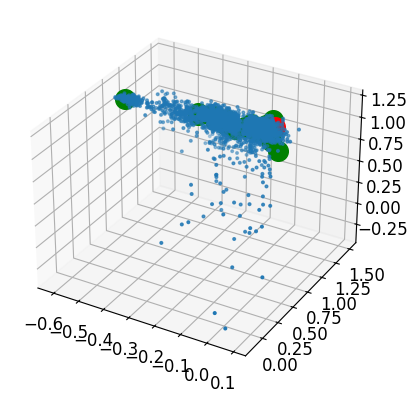

In [7]:
# Swiss roll random integer
# np.random.seed(3450)
# np.random.seed(3451)
# np.random.seed(3452)
np.random.seed(345123)
npts = data['mask_x'].sum()
zs = []
n = 20
for i in range(n):
    start = np.random.randint(0,npts,size=1)
    # end = np.random.randint(0,npts,size=1)
    zs.append(torch.tensor(z[start,:]).cpu())
    # xends.append(torch.tensor(z[end,:]).cpu())
end = np.random.randint(0,npts,size=1)
# zfin = torch.tensor([[0,0,1]], dtype=torch.float32)
zfin = torch.tensor(z[end,:]).cpu() 
zbatch = torch.cat(zs,0)
zendbatch = torch.cat([zfin for i in range(n)],0)

print(zfin.shape)
print(zbatch.shape)
print(zendbatch.shape)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(z.detach().cpu().numpy(), ax=ax)
for i in range(zbatch.shape[0]):
    scprep.plot.scatter3d(zbatch[i].detach().cpu().numpy(), ax=ax, c='g')
    # scprep.plot.scatter2d(zhat_no_len_reg[:,i,:].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter3d(zfin[0].detach().cpu().numpy(), ax=ax, c='r')

with torch.no_grad():
    xbatch = model.decoder(zbatch, unnormalize=False)
    xendbatch = model.decoder(zendbatch, unnormalize=False)

dataset = TensorDataset(xbatch, xendbatch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
def func(x):
    return model.encoder(x)

gbmodel = GeodesicBridge(
    func=func,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=3, 
    n_tsteps=100, 
    lr=1e-3, 
    weight_decay=1e-5,
)
trainer = pl.Trainer(max_epochs=200)
trainer.fit(gbmodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning:

You defined a

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [9]:
trainer.save_checkpoint("eb_1.5.ckpt")

In [10]:
x0, x1 = next(iter(dataloader))
x0, x1 = next(iter(dataloader))
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts)

In [11]:
import torch
xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten, normalize=False)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0, normalize=False)
    z1 = model.encoder(x1, normalize=False)

In [15]:
fig = scatter(zh.cpu().numpy(), data['mask_x'], s=2)
fig = scatter(z0.detach().cpu().numpy(), s=10, fig=fig)
fig = scatter(z1.detach().cpu().numpy(), s=10, fig=fig)
# fig = trajectories(longitudelines.detach().cpu().numpy(), s=5, c='blue', fig=fig)
fig = trajectories(zhat.detach().cpu().numpy(), s=10, fig=fig, title='Geodesic Bridge', filename='hsphere_geod_1.0.html')
fig.show()